In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import export_text
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from IPython.display import display

!pip install xgboost
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
df = pd.read_csv("finpay_data.csv", on_bad_lines='skip')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

for col in df.columns:
    if 'date' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [4]:
df.dtypes

wallet_id                        object
onboard_date             datetime64[ns]
user_class                       object
state                            object
gender                           object
region                           object
last_trans_date          datetime64[ns]
first_trans_date         datetime64[ns]
days_since_last_txn              object
days_to_first_txn                object
tenure_days                      object
age                               int64
total_txn_count                  object
total_tpv                        object
avg_tpv                          object
txn_count_30d                    object
tpv_30d                          object
avg_txn_value_30d                object
txn_count_90d                    object
tpv_90d                          object
avg_txn_value_90d                object
txn_trend                       float64
tpv_trend                       float64
avg_days_between_txn            float64
pos_share                       float64


In [5]:
df.isna().sum()

wallet_id                   0
onboard_date                0
user_class                  0
state                     357
gender                   4552
region                      0
last_trans_date          2182
first_trans_date         2182
days_since_last_txn      4498
days_to_first_txn        2182
tenure_days                 0
age                         0
total_txn_count             0
total_tpv                   0
avg_tpv                     0
txn_count_30d               0
tpv_30d                     0
avg_txn_value_30d           0
txn_count_90d               0
tpv_90d                     0
avg_txn_value_90d           0
txn_trend                   0
tpv_trend                   0
avg_days_between_txn        0
pos_share                   0
transfer_share              0
digital_service_share       0
loan_share                  0
deposit_share               0
total_commission            0
success_rate                0
churn_flag                  0
dtype: int64

In [6]:
cols_to_convert = [
    'days_to_first_txn',
    'days_since_last_txn',
    'tenure_days',
    'total_txn_count',
    'total_tpv',
    'avg_tpv',
    'txn_count_30d',
    'tpv_30d',
    'avg_txn_value_30d',
    'txn_count_90d',
    'tpv_90d',
    'avg_txn_value_90d',
    'total_commission'
]


for col in cols_to_convert:
    df[col] = (
        df[col]
        .astype(str)                        
        .str.replace(',', '', regex=False)  
        .str.replace('₦', '', regex=False)  
        .str.strip()                        
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')  

df[cols_to_convert] = df[cols_to_convert].fillna(0)

In [7]:
df.head()

,wallet_id,onboard_date,user_class,state,gender,region,last_trans_date,first_trans_date,days_since_last_txn,days_to_first_txn,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,3c24443b-c103-442b-8d01-82b3e21d4866,2023-05-12,Terminal User,Ebonyi,Male,South East,2024-06-21 19:37:00,2023-05-12 12:01:00,510.0,406.0,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,10a7707a-1880-4e9e-8883-50cb61485a63,2025-01-26,App User,Akwa Ibom,Male,South South,2025-02-06 17:45:00,2025-02-02 15:21:00,280.0,4.0,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,05345902-e5d8-40f2-b801-26169b5d8950,2023-08-02,Terminal User,Ondo,NaN,South West,2025-01-05 11:08:00,2023-08-02 16:43:00,312.0,522.0,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,ebd6819c-3af1-4d71-b035-24071c65651a,2025-01-30,App User,NaN,Male,Other,NaT,NaT,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,b4cee700-1a9f-4e19-a0d7-0a388154039c,2023-12-05,App User,Kwara,Male,South West,NaT,NaT,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [8]:
df.drop(columns=['onboard_date', 'first_trans_date', 'last_trans_date', 'wallet_id'], inplace=True)

In [9]:
df.columns

Index(['user_class', 'state', 'gender', 'region', 'days_since_last_txn',
       'days_to_first_txn', 'tenure_days', 'age', 'total_txn_count',
       'total_tpv', 'avg_tpv', 'txn_count_30d', 'tpv_30d', 'avg_txn_value_30d',
       'txn_count_90d', 'tpv_90d', 'avg_txn_value_90d', 'txn_trend',
       'tpv_trend', 'avg_days_between_txn', 'pos_share', 'transfer_share',
       'digital_service_share', 'loan_share', 'deposit_share',
       'total_commission', 'success_rate', 'churn_flag'],
      dtype='object')

In [10]:
df.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,Terminal User,Ebonyi,Male,South East,510.0,406.0,916,39,3672,8564647.98,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,App User,Akwa Ibom,Male,South South,280.0,4.0,291,0,10,1200.00,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,Terminal User,Ondo,NaN,South West,312.0,522.0,834,36,4,2000.00,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,App User,NaN,Male,Other,0.0,0.0,287,0,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,App User,Kwara,Male,South West,0.0,0.0,709,32,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [11]:
df.isna().sum()

user_class                  0
state                     357
gender                   4552
region                      0
days_since_last_txn         0
days_to_first_txn           0
tenure_days                 0
age                         0
total_txn_count             0
total_tpv                   0
avg_tpv                     0
txn_count_30d               0
tpv_30d                     0
avg_txn_value_30d           0
txn_count_90d               0
tpv_90d                     0
avg_txn_value_90d           0
txn_trend                   0
tpv_trend                   0
avg_days_between_txn        0
pos_share                   0
transfer_share              0
digital_service_share       0
loan_share                  0
deposit_share               0
total_commission            0
success_rate                0
churn_flag                  0
dtype: int64

In [12]:
df['state'] = df['state'].fillna('unknown')
df['gender'] = df['gender'].fillna('unknown')

In [13]:
df.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,Terminal User,Ebonyi,Male,South East,510.0,406.0,916,39,3672,8564647.98,...,0.0,0.11,0.17,0.13,0.69,0.0,0.0087,55080000,0.83,1
1,App User,Akwa Ibom,Male,South South,280.0,4.0,291,0,10,1200.00,...,0.0,0.44,0.00,0.40,0.20,0.0,0.4000,2000,0.80,1
2,Terminal User,Ondo,unknown,South West,312.0,522.0,834,36,4,2000.00,...,0.0,174.00,0.00,0.25,0.00,0.0,0.7500,0,1.00,1
3,App User,unknown,Male,Other,0.0,0.0,287,0,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0
4,App User,Kwara,Male,South West,0.0,0.0,709,32,0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0000,0,0.00,0


In [14]:
df.isna().sum()

user_class               0
state                    0
gender                   0
region                   0
days_since_last_txn      0
days_to_first_txn        0
tenure_days              0
age                      0
total_txn_count          0
total_tpv                0
avg_tpv                  0
txn_count_30d            0
tpv_30d                  0
avg_txn_value_30d        0
txn_count_90d            0
tpv_90d                  0
avg_txn_value_90d        0
txn_trend                0
tpv_trend                0
avg_days_between_txn     0
pos_share                0
transfer_share           0
digital_service_share    0
loan_share               0
deposit_share            0
total_commission         0
success_rate             0
churn_flag               0
dtype: int64

In [15]:
df.describe().round()

,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,avg_tpv,txn_count_30d,tpv_30d,avg_txn_value_30d,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
count,10523.0,10523.0,10523.0,10523.0,10523.0,1.052300e+04,10523.0,10523.0,10523.0,10523.0,...,10523.0,10523.0,10523.0,10523.0,10523.0,10523.0,10523.0,1.052300e+04,10523.0,10523.0
mean,289.0,217.0,869.0,16.0,688.0,3.216126e+07,36611.0,4.0,67248.0,889.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.032714e+08,1.0,1.0
std,363.0,319.0,249.0,19.0,2025.0,1.950810e+09,2471492.0,29.0,916802.0,5915.0,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,6.779008e+09,0.0,0.0
min,0.0,0.0,29.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.837500e+05,0.0,0.0
25%,0.0,0.0,756.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
50%,35.0,20.0,1006.0,0.0,5.0,7.920000e+03,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.400000e+03,1.0,1.0
75%,595.0,353.0,1006.0,35.0,360.0,3.945652e+06,9746.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.532200e+05,1.0,1.0
max,1354.0,1289.0,1361.0,55.0,59274.0,2.000160e+11,253184810.0,1089.0,72873355.0,184579.0,...,1.0,532.0,1.0,1.0,1.0,0.0,1.0,6.240347e+11,1.0,1.0


In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)  
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [17]:
len(df_train), len(df_test), len(df_val)

(6313, 2105, 2105)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = (df_train.churn_flag).astype('int').values
y_val = (df_val.churn_flag).astype('int').values
y_test = (df_test.churn_flag).astype('int').values

In [20]:
del df_train['churn_flag']
del df_val['churn_flag']
del df_test['churn_flag']

In [21]:
df_train.head()

,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,total_tpv,...,txn_trend,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate
0,Terminal User,Edo,Female,South South,407.0,173.0,580,34,289,4571990.00,...,0.0,0.0,0.60,0.22,0.40,0.021,0.0,0.360,3944850,0.85
1,App User,Anambra,unknown,South East,0.0,0.0,1006,0,0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.000,0.0,0.000,300,0.00
2,App User,Lagos,unknown,Lagos,865.0,182.0,1008,53,102,2016295.08,...,0.0,0.0,1.39,0.25,0.57,0.140,0.0,0.039,3008592,0.88
3,App User,Oyo,Male,South West,0.0,0.0,678,47,0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.000,0.0,0.000,0,0.00
4,App User,Lagos,unknown,Lagos,929.0,107.0,1006,0,1,200.00,...,0.0,0.0,0.00,0.00,0.00,1.000,0.0,0.000,21292,1.00


In [22]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
X_train

array([[3.400000e+01, 6.000000e-01, 1.582003e+04, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [5.300000e+01, 1.390000e+00, 1.976760e+04, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [3.700000e+01, 9.000000e-02, 2.488343e+04, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [4.500000e+01, 2.050000e+00, 1.225469e+04, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00]], shape=(6313, 74))

In [24]:
features = dv.get_feature_names_out()
pd.Series(features).value_counts()

age                         1
avg_days_between_txn        1
avg_tpv                     1
avg_txn_value_30d           1
avg_txn_value_90d           1
                           ..
txn_count_30d               1
txn_count_90d               1
txn_trend                   1
user_class=App User         1
user_class=Terminal User    1
Name: count, Length: 74, dtype: int64

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [26]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1821, 4492]))

In [27]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9972476138390822

In [29]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.851
   2 -> 0.961
   3 -> 0.986
   4 -> 0.997
   5 -> 0.998
   6 -> 0.997
  10 -> 0.996
  15 -> 0.997
  20 -> 0.997
None -> 0.997


In [30]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- days_since_last_txn <= 59.50
|   |--- tenure_days <= 979.50
|   |   |--- class: 0
|   |--- tenure_days >  979.50
|   |   |--- days_to_first_txn <= 535.50
|   |   |   |--- tenure_days <= 1007.00
|   |   |   |   |--- class: 1
|   |   |   |--- tenure_days >  1007.00
|   |   |   |   |--- class: 0
|   |   |--- days_to_first_txn >  535.50
|   |   |   |--- class: 0
|--- days_since_last_txn >  59.50
|   |--- days_to_first_txn <= 979.50
|   |   |--- tenure_days <= 85.50
|   |   |   |--- avg_txn_value_90d <= 4176.82
|   |   |   |   |--- class: 1
|   |   |   |--- avg_txn_value_90d >  4176.82
|   |   |   |   |--- class: 0
|   |   |--- tenure_days >  85.50
|   |   |   |--- state=Cross-River <= 0.50
|   |   |   |   |--- txn_count_90d <= 8.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- txn_count_90d >  8.50
|   |   |   |   |   |--- transfer_share <= 0.33
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- transfer_share >  0.33
|   |   |   |   |   |   |--- class: 0
|   |   

In [31]:
scoresd = []

for d in [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None]:
    for s in [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scoresd.append((d, s, auc))

In [32]:
scores_d = pd.DataFrame(scoresd, columns=['max_depth', 'min_samples_leaf', 'auc'])
scores_d.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
267,NaN,80,0.999081
219,40.0,80,0.999081
203,35.0,80,0.999081
171,25.0,80,0.999081
139,15.0,80,0.999081
...,...,...,...
4,1.0,15,0.850684
2,1.0,5,0.850684
3,1.0,10,0.850684
0,1.0,1,0.850684


In [33]:
df_scoresd_pivot = scores_d.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])
df_scoresd_pivot.round(3)

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    7.0    
min_samples_leaf                                                           
1                 0.997  0.851  0.961  0.986  0.997  0.998  0.997  0.997   
2                 0.998  0.851  0.961  0.986  0.997  0.998  0.997  0.998   
5                 0.998  0.851  0.961  0.986  0.997  0.998  0.998  0.998   
10                0.998  0.851  0.961  0.986  0.998  0.998  0.998  0.998   
15                0.998  0.851  0.961  0.986  0.998  0.998  0.998  0.998   
20                0.998  0.851  0.961  0.987  0.998  0.998  0.998  0.998   
30                0.998  0.851  0.961  0.986  0.998  0.998  0.998  0.998   
40                0.998  0.851  0.961  0.986  0.998  0.998  0.998  0.998   
50                0.998  0.851  0.961  0.986  0.998  0.998  0.998  0.998   
60                0.998  0.851  0.961  0.986  0.998  0.998  0.997  0.997   
70                0.997  0.851  0.961  0.986  0.998  0.997  0.997  0.997   
80                0.999  0.851  0.961  0.987  0.998  0.999  0.999  0.999   
90                0.999  0.851  0.961  0.986  0.999  0.998  0.998  0.999   
100               0.999  0.851  0.961  0.986  0.998  0.998  0.999  0.999   
200               0.996  0.851  0.961  0.986  0.994  0.996  0.996  0.996   
500               0.987  0.851  0.962  0.980  0.988  0.987  0.987  0.987   

                                                                          \
max_depth          10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0   
min_samples_leaf                                                           
1                 0.996  0.996  0.996  0.997  0.996  0.997  0.996  0.997   
2                 0.997  0.998  0.998  0.997  0.998  0.997  0.998  0.997   
5                 0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
10                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
15                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
20                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
30                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
40                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
50                0.998  0.998  0.998  0.998  0.998  0.998  0.998  0.998   
60                0.998  0.998  0.997  0.997  0.998  0.998  0.997  0.998   
70                0.998  0.997  0.998  0.997  0.997  0.998  0.997  0.998   
80                0.999  0.999  0.999  0.999  0.998  0.999  0.999  0.998   
90                0.999  0.998  0.998  0.999  0.998  0.999  0.999  0.998   
100               0.999  0.999  0.998  0.999  0.998  0.999  0.999  0.999   
200               0.996  0.996  0.996  0.996  0.996  0.996  0.996  0.996   
500               0.988  0.988  0.987  0.987  0.988  0.987  0.987  0.987   

                         
max_depth          50.0  
min_samples_leaf         
1                 0.996  
2                 0.997  
5                 0.998  
10                0.998  
15                0.998  
20                0.998  
30                0.998  
40                0.998  
50                0.998  
60                0.997  
70                0.998  
80                0.999  
90                0.998  
100               0.999  
200               0.996  
500               0.987

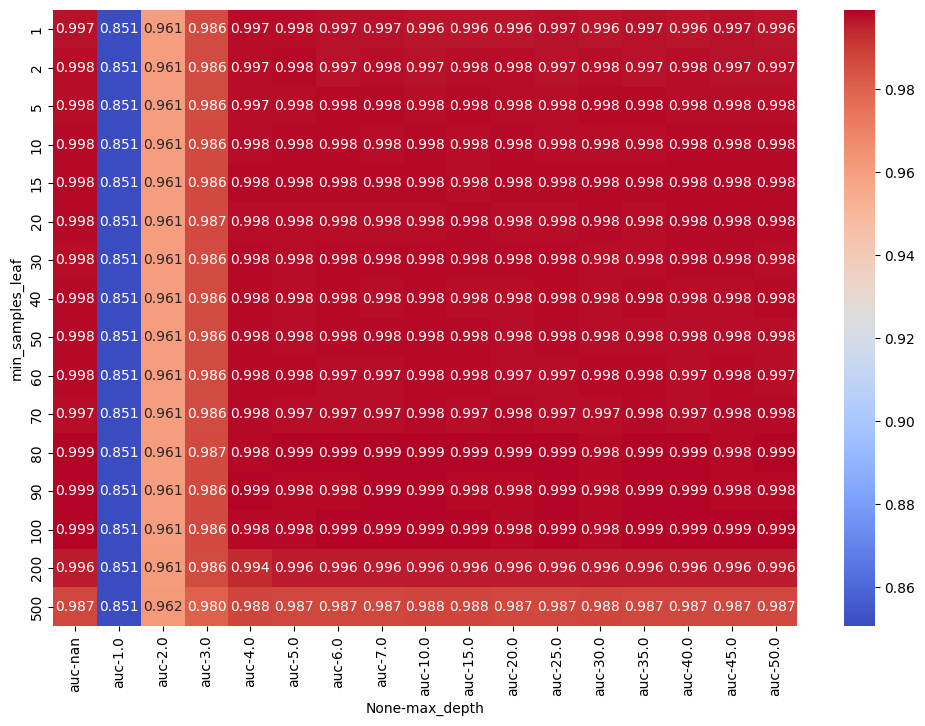

In [34]:
plt.figure(figsize=(12, 8))  # width=12, height=8
sns.heatmap(df_scoresd_pivot, annot=True, fmt='.3f', cmap='coolwarm')  # optional: add a color map
plt.show()

In [35]:
best_score = df_scoresd_pivot.max().max()
best_leaf, best_depth = np.where(df_scoresd_pivot == best_score)

In [36]:
best_min_leaf = df_scoresd_pivot.index[best_leaf[0]]
best_max_depth = df_scoresd_pivot.columns[best_depth[0]]

In [37]:
print(f"✅ Best score: {best_score}")
print(f"🌿 Best min_samples_leaf: {best_min_leaf}")
print(f"🌳 Best max_depth: {best_max_depth}")

✅ Best score: 0.9990809102786132
🌿 Best min_samples_leaf: 80
🌳 Best max_depth: ('auc', nan)


In [38]:
#final tuning max_depth = 10 and min_samples_leaf = 30
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,30
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [39]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9983522576836769

In [40]:
scorerf = []
for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scorerf.append((n, auc))

In [41]:
scoress_rf = pd.DataFrame(scorerf, columns=['n_estimator', 'auc'])
scoress_rf.sort_values(by='auc', ascending=False)

,n_estimator,auc
2,30,0.998212
3,40,0.998211
4,50,0.998203
6,70,0.998199
5,60,0.998195
7,80,0.998192
8,90,0.998188
1,20,0.998180
9,100,0.998171
10,110,0.998141


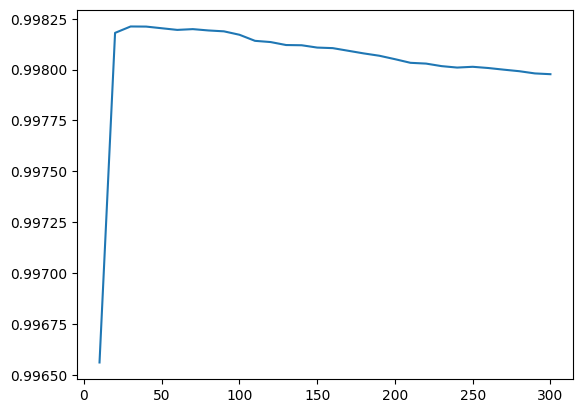

In [42]:
plt.plot(scoress_rf.n_estimator, scoress_rf.auc)

In [43]:
scorerfd = []

for d in [10, 15, 20, 25, 30, 35, 40]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scorerfd.append((n, d, auc))

In [44]:
scored_rdf = pd.DataFrame(scorerfd, columns=['n_estimator', 'max_depth', 'auc'])

In [45]:
scored_rdf.sort_values(by='auc')

,n_estimator,max_depth,auc
120,10,30,0.996561
150,10,35,0.996561
180,10,40,0.996561
60,10,20,0.997296
90,10,25,0.997315
...,...,...,...
9,100,10,0.999159
8,90,10,0.999197
5,60,10,0.999200
7,80,10,0.999210


In [46]:
max_depth = 10
min_samples_leaf = 30
n_estimator = 260

In [47]:
rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,260
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,30
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

auc

0.9988226536626865

In [49]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [50]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [51]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9993435073418667

In [52]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

learning_rates = [0.3, 0.2, 0.1, 0.05, 0.01]

for lr in learning_rates:
    xgb_params['learning_rate'] = lr
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"LR: {lr}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.99770
[1]	validation-auc:0.99787
[2]	validation-auc:0.99790
[3]	validation-auc:0.99789
[4]	validation-auc:0.99790
[5]	validation-auc:0.99789
[6]	validation-auc:0.99789
[7]	validation-auc:0.99822
[8]	validation-auc:0.99823
[9]	validation-auc:0.99854
[10]	validation-auc:0.99856
[11]	validation-auc:0.99856
[12]	validation-auc:0.99861
[13]	validation-auc:0.99857
[14]	validation-auc:0.99858
[15]	validation-auc:0.99858
[16]	validation-auc:0.99906
[17]	validation-auc:0.99907
[18]	validation-auc:0.99949
[19]	validation-auc:0.99948
[20]	validation-auc:0.99920
[21]	validation-auc:0.99920
[22]	validation-auc:0.99921
[23]	validation-auc:0.99934
[24]	validation-auc:0.99934
[25]	validation-auc:0.99933
[26]	validation-auc:0.99945
[27]	validation-auc:0.99949
[28]	validation-auc:0.99949
[29]	validation-auc:0.99945
[30]	validation-auc:0.99951
[31]	validation-auc:0.99950
[32]	validation-auc:0.99947
[33]	validation-auc:0.99948
[34]	validation-auc:0.99946
[35]	validation-auc:0.99935
[3

In [53]:
#LR: 0.01, Best AUC: 0.9996429443625549, Best iteration: 107
#LR: 0.05, Best AUC: 0.9998364630668191, Best iteration: 89
#LR: 0.1, Best AUC: 0.9998288313432706, Best iteration: 41
#LR: 0.2, Best AUC: 0.9998321020819342, Best iteration: 20
#LR: 0.3, Best AUC: 0.9998380984361508, Best iteration: 13

dic = {"0.01": 0.9996429443625549, "0.05": 0.9998364630668191, "0.1": 0.9998288313432706, "0.2": 0.9998321020819342, "0.3": 0.9998380984361508}
best_lr = max(dic, key=dic.get)
print("Best learning rate:", best_lr)

Best learning rate: 0.3


In [54]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

max_depth_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]

for md in max_depth_values:
    xgb_params['max_depth'] = md
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"MD: {md}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.96057
[1]	validation-auc:0.98598
[2]	validation-auc:0.98498
[3]	validation-auc:0.98598
[4]	validation-auc:0.99390
[5]	validation-auc:0.99370
[6]	validation-auc:0.99364
[7]	validation-auc:0.99729
[8]	validation-auc:0.99762
[9]	validation-auc:0.99761
[10]	validation-auc:0.99777
[11]	validation-auc:0.99777
[12]	validation-auc:0.99772
[13]	validation-auc:0.99791
[14]	validation-auc:0.99808
[15]	validation-auc:0.99813
[16]	validation-auc:0.99813
[17]	validation-auc:0.99881
[18]	validation-auc:0.99885
[19]	validation-auc:0.99885
[20]	validation-auc:0.99885
[21]	validation-auc:0.99885
[22]	validation-auc:0.99885
[23]	validation-auc:0.99885
[24]	validation-auc:0.99902
[25]	validation-auc:0.99900
[26]	validation-auc:0.99901
[27]	validation-auc:0.99901
[28]	validation-auc:0.99900
[29]	validation-auc:0.99900
[30]	validation-auc:0.99900
[31]	validation-auc:0.99899
[32]	validation-auc:0.99901
[33]	validation-auc:0.99897
[34]	validation-auc:0.99901
[35]	validation-auc:0.99897
[3

In [55]:
#2, Best AUC: 0.9998778924232249, Best iteration: 88
#MD: 3, Best AUC: 0.9997263481984772, Best iteration: 39
#MD: 4, Best AUC: 0.9998648094685704, Best iteration: 22
#MD: 5, Best AUC: 0.9997955788335238, Best iteration: 9
#MD: 6, Best AUC: 0.9998380984361508, Best iteration: 13
#MD: 7, Best AUC: 0.9998211996197222, Best iteration: 13
#MD: 8, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 9, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 10, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 12, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 15, Best AUC: 0.999820109373501, Best iteration: 14
#MD: 20, Best AUC: 0.999820109373501, Best iteration: 14

dicmd = {"2": 0.9998778924232249, "3": 0.9997263481984772,  
"4": 0.9998648094685704, "5": 0.9997955788335238, "6": 0.9998380984361508, 
"7":  0.9998211996197222, "8": 0.999820109373501, "9": 0.999820109373501, "10": 0.999820109373501,
"12":  0.999820109373501, "15": 0.999820109373501, "20": 0.999820109373501 }

best_md = max(dicmd, key=dicmd.get)
print("Best max depth:", best_md)
print("Highest value:", dicmd[best_md])

Best max depth: 2
Highest value: 0.9998778924232249


In [56]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

min_child_weight_values = [1, 2, 3, 4, 5, 7, 10, 15, 20]

for mcw in min_child_weight_values:
    xgb_params['learning_rate'] = mcw
    model = xgb.train(
        xgb_params, dtrain, num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )
    print(f"MCW: {mcw}, Best AUC: {model.best_score}, Best iteration: {model.best_iteration}")

[0]	validation-auc:0.99770
[1]	validation-auc:0.99791
[2]	validation-auc:0.99864
[3]	validation-auc:0.99856
[4]	validation-auc:0.99954
[5]	validation-auc:0.99954
[6]	validation-auc:0.99921
[7]	validation-auc:0.99957
[8]	validation-auc:0.99951
[9]	validation-auc:0.99926
[10]	validation-auc:0.99954
[11]	validation-auc:0.99956
[12]	validation-auc:0.99958
[13]	validation-auc:0.99958
[14]	validation-auc:0.99962
[15]	validation-auc:0.99964
[16]	validation-auc:0.99961
[17]	validation-auc:0.99961
[18]	validation-auc:0.99961
[19]	validation-auc:0.99961
[20]	validation-auc:0.99958
[21]	validation-auc:0.99959
[22]	validation-auc:0.99948
[23]	validation-auc:0.99946
[24]	validation-auc:0.99944
[25]	validation-auc:0.99946
[26]	validation-auc:0.99946
[27]	validation-auc:0.99944
[28]	validation-auc:0.99943
[29]	validation-auc:0.99940
[30]	validation-auc:0.99940
[31]	validation-auc:0.99940
[32]	validation-auc:0.99940
[33]	validation-auc:0.99940
[34]	validation-auc:0.99940
[35]	validation-auc:0.99940
[3

In [57]:
dicmcw = {
 1: 0.9998658997147916,
 2: 0.9997606909544452,
 3: 0.9929935326594158,
 4: 0.9929935326594158,
 5: 0.9929935326594158,
 7: 0.9929935326594158,
 10: 0.9920777258336022,
 15: 0.9920777258336022,
 20: 0.9920875380495932
}



best_mcw = max(dicmcw, key=dicmcw.get)
print("Best min_child_weight:", best_mcw)
print("Highest value:", dicmcw[best_mcw])


Best min_child_weight: 1
Highest value: 0.9998658997147916


In [58]:
#min_child_weight = 1
#max_depth = 2
#eta = 0.3

In [59]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)


y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9994102417195116

In [60]:
all_model = {"dt": 0.9995061184617934,
"rf": 0.9991463372087952, "xgb": 0.9998380984361508}

best_model = max(all_model, key=all_model.get)
print("Best model:", best_model)
print("Best model auc score:", all_model[best_model])

Best model: xgb
Best model auc score: 0.9998380984361508


In [61]:
#XGB is the best

In [62]:
df_full_train = df_full_train.reset_index()

In [63]:
df_full_train.head()

,index,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,...,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate,churn_flag
0,7845,App User,Lagos,unknown,Lagos,876.0,161.0,1006,0,1017,...,0.0,0.13,0.00,0.031,0.690,0.0,0.28,1452276,0.97,1
1,1079,App User,Enugu,unknown,South East,756.0,281.0,1006,36,836,...,0.0,0.30,0.00,0.170,0.730,0.0,0.10,2584912,0.91,1
2,715,Terminal User,Akwa Ibom,Male,South South,169.0,670.0,839,48,10760,...,0.0,0.06,0.46,0.160,0.210,0.0,0.17,31795800,0.92,1
3,6201,App User,Delta,Male,South South,242.0,107.0,351,0,32,...,0.0,3.45,0.00,0.840,0.031,0.0,0.13,288000,0.62,1
4,8579,App User,Ondo,unknown,South West,0.0,0.0,942,0,0,...,0.0,0.00,0.00,0.000,0.000,0.0,0.00,0,0.00,0


In [64]:
y_full_train = (df_full_train.churn_flag == 1).astype(int).values

In [65]:
y_full_train

array([1, 1, 1, ..., 1, 1, 1], shape=(8418,))

In [66]:
del df_full_train['churn_flag']

In [67]:
df_full_train.head()

,index,user_class,state,gender,region,days_since_last_txn,days_to_first_txn,tenure_days,age,total_txn_count,...,txn_trend,tpv_trend,avg_days_between_txn,pos_share,transfer_share,digital_service_share,loan_share,deposit_share,total_commission,success_rate
0,7845,App User,Lagos,unknown,Lagos,876.0,161.0,1006,0,1017,...,0.0,0.0,0.13,0.00,0.031,0.690,0.0,0.28,1452276,0.97
1,1079,App User,Enugu,unknown,South East,756.0,281.0,1006,36,836,...,0.0,0.0,0.30,0.00,0.170,0.730,0.0,0.10,2584912,0.91
2,715,Terminal User,Akwa Ibom,Male,South South,169.0,670.0,839,48,10760,...,0.0,0.0,0.06,0.46,0.160,0.210,0.0,0.17,31795800,0.92
3,6201,App User,Delta,Male,South South,242.0,107.0,351,0,32,...,0.0,0.0,3.45,0.00,0.840,0.031,0.0,0.13,288000,0.62
4,8579,App User,Ondo,unknown,South West,0.0,0.0,942,0,0,...,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.00,0,0.00


In [68]:
dict_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

dict_test = df_test.to_dict(orient='records')
X_test = dv.transform(dict_test)

In [69]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [70]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)


y_pred = model.predict(dtest)
roc_auc_score(y_val, y_pred)

0.49799579844698794

In [71]:
#second best on training
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
dt.fit(X_full_train, y_full_train)
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

1.0

In [72]:
rf = RandomForestClassifier(n_estimators=260, max_depth=10, min_samples_leaf=30, random_state=1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_val, y_pred)

auc

0.5025934172775847

In [2]:
#Decision tree gave me the best which is data leaskage I have tried to resolve it I could not